In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from random import randint
np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import shutil
from tqdm import tqdm

import  sys

def mem_size(variable):
    return sys.getsizeof(variable)*1e-6


def RAM():
    tot = 0
    for i in dir():
            tot=tot+mem_size(i)
            #print(i,"--",'{:f}'.format(mem_size(i))," MB")

    print('Total size by var: ','{:f}'.format(tot))
    

In [3]:
skin_df = pd.read_csv('C:/Users/RAZER/Downloads/dataset/HAM/HAM10000_metadata.csv')

In [4]:
skin_df["dx"].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [5]:
len(skin_df.query("dx == 'nv'")["image_id"].unique())

6705

In [6]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization        dataset  label  
1617             face   vidir_modern      4  
8128  lower extremity    vienna_dias      5  
2168             back      rosendahl      4  
1090            trunk  vidir_molemax      2  
775

c:\Users\RAZER\anaconda3\envs\Banded_krait\lib\site-packages\ipykernel_launcher.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



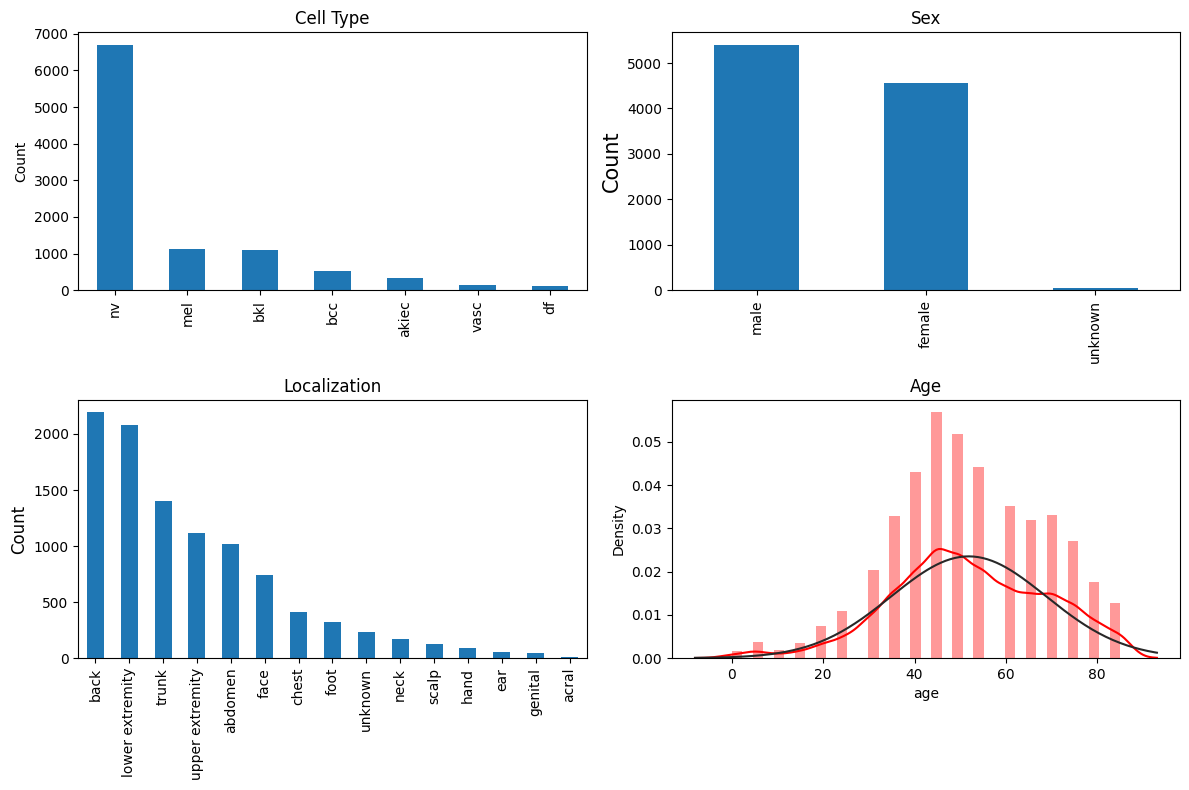

In [7]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [8]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


#Making a Balance

In [9]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [10]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                            df_2_balanced, df_3_balanced, 
                            df_4_balanced, df_5_balanced, df_6_balanced])


In [11]:

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())
skin_df_balanced=skin_df_balanced.reset_index(drop=True)

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [12]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
0,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,rosendahl,0
1,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,rosendahl,0
2,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,rosendahl,0
3,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,rosendahl,0
4,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,rosendahl,0
...,...,...,...,...,...,...,...,...,...
3495,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,vidir_modern,6
3496,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,vidir_molemax,6
3497,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,vidir_molemax,6
3498,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,vidir_modern,6


In [13]:
label = skin_df_balanced['dx'].unique().tolist()
label

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [14]:
skin_df_balanced['dx'].value_counts()

akiec    500
bcc      500
bkl      500
df       500
mel      500
nv       500
vasc     500
Name: dx, dtype: int64

In [15]:
len(skin_df_balanced.query("dx == 'vasc'")["image_id"].unique())

137

In [16]:
destination = "C:/Users/RAZER/Downloads/dataset/HAM/Refactored/"
img_path = "C:/Users/RAZER/Downloads/dataset/HAM/all_images/"

In [17]:
try:
    for i in label:
        os.makedirs(destination+i)

    for i in tqdm(range(skin_df_balanced.shape[0])):
        final_deestination = destination+skin_df_balanced["dx"][i]
        final_source = img_path+skin_df_balanced["image_id"][i]+".jpg"
        shutil.copy(final_source,final_deestination)


    img_cls_folder = glob(destination+"*")


    print("Before Balancing>>>>")
    for i in img_cls_folder:
        base_name = os.path.basename(i)
        print(base_name,"--",len(glob(i+"/*")))
    print()
    print("Balancing Start")


    for folder in tqdm(img_cls_folder):
        single_folder = glob(folder+"/*")
        fold_len = len(single_folder)

        for i in range(500 - fold_len):
            final_source = single_folder[randint(0, len(single_folder)-1)]
            base_name = os.path.basename(final_source)
            shutil.copy(final_source,folder+"\\"+str(i)+base_name)


    img_cls_folder = glob(destination+"*")
    
    for i in img_cls_folder:
        base_name = os.path.basename(i)
        print(base_name,"--",len(glob(i+"/*")))



except Exception as exc:
    print(exc)

[WinError 183] Cannot create a file when that file already exists: 'C:/Users/RAZER/Downloads/dataset/HAM/Refactored/akiec'


In [18]:
RAM()

Total size by var:  0.000052


In [19]:
from keras.preprocessing.image import ImageDataGenerator
import os
from matplotlib import pyplot as plt


In [20]:
#Define datagen. Here we can define any transformations we want to apply to images
datagen = ImageDataGenerator()

In [21]:
train_dir = "C:/Users/RAZER/Downloads/dataset/HAM/Refactored/"

In [34]:
#USe flow_from_directory
train_data_keras = datagen.flow_from_directory(directory=train_dir, 
                                                class_mode='categorical',
                                                batch_size=3500,  #16 images at a time
                                                target_size=(32,32))  #Resize images


Found 3500 images belonging to 7 classes.


In [35]:
x, y = next(train_data_keras)


In [36]:
x.shape

(3500, 32, 32, 3)

In [39]:
y.shape

(3500, 7)

In [53]:
"""
#View each image
for i in range (0,15):
    image = x[i].astype(int)
    plt.imshow(image)
    plt.show()"""

'\n#View each image\nfor i in range (0,15):\n    image = x[i].astype(int)\n    plt.imshow(image)\n    plt.show()'

In [40]:
x = x/255
#y_cat = to_categorical(y, num_classes=7)
y_cat = y

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.25, random_state=42)

In [42]:
y_test.shape

(875, 7)

In [59]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))


In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 6, 6, 128)        

In [61]:

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [56]:
batch_size = 32
epochs = 70

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)


Epoch 1/70
83/83 - 1s - loss: 0.3151 - acc: 0.8819 - val_loss: 0.7477 - val_acc: 0.7829 - 683ms/epoch - 8ms/step
Epoch 2/70
83/83 - 0s - loss: 0.2986 - acc: 0.8895 - val_loss: 0.7406 - val_acc: 0.7806 - 483ms/epoch - 6ms/step
Epoch 3/70
83/83 - 0s - loss: 0.2954 - acc: 0.8903 - val_loss: 0.7536 - val_acc: 0.7749 - 466ms/epoch - 6ms/step
Epoch 4/70
83/83 - 0s - loss: 0.3679 - acc: 0.8644 - val_loss: 0.7529 - val_acc: 0.7886 - 460ms/epoch - 6ms/step
Epoch 5/70
83/83 - 0s - loss: 0.2805 - acc: 0.8994 - val_loss: 0.7448 - val_acc: 0.7691 - 445ms/epoch - 5ms/step
Epoch 6/70
83/83 - 0s - loss: 0.2902 - acc: 0.8937 - val_loss: 0.7552 - val_acc: 0.7783 - 481ms/epoch - 6ms/step
Epoch 7/70
83/83 - 0s - loss: 0.2861 - acc: 0.8964 - val_loss: 0.8356 - val_acc: 0.7703 - 455ms/epoch - 5ms/step
Epoch 8/70
83/83 - 0s - loss: 0.4792 - acc: 0.8324 - val_loss: 0.7483 - val_acc: 0.7737 - 445ms/epoch - 5ms/step
Epoch 9/70
83/83 - 0s - loss: 0.4015 - acc: 0.8651 - val_loss: 0.7531 - val_acc: 0.7886 - 451ms/

In [57]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 0s 9ms/step - loss: 0.7763 - acc: 0.7897
Test accuracy: 0.7897142767906189


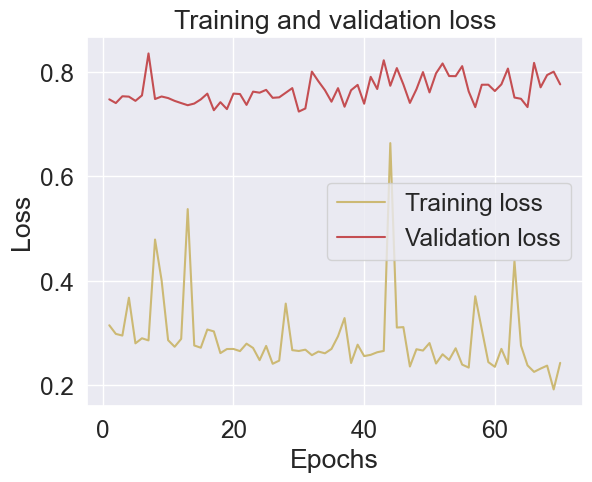

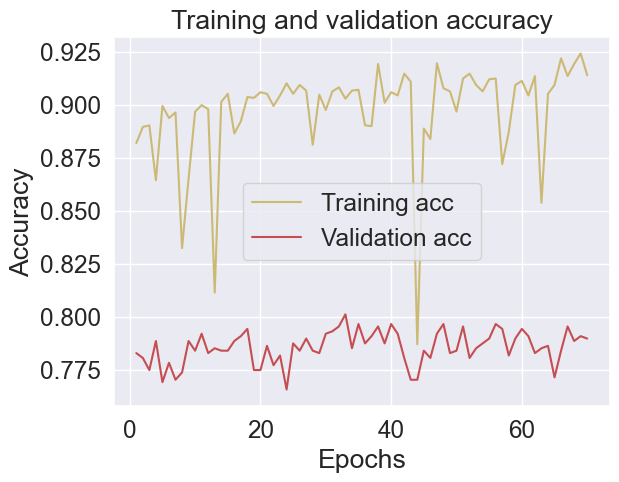

In [58]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

28/28 [==============================] - 0s 9ms/step


<AxesSubplot:>

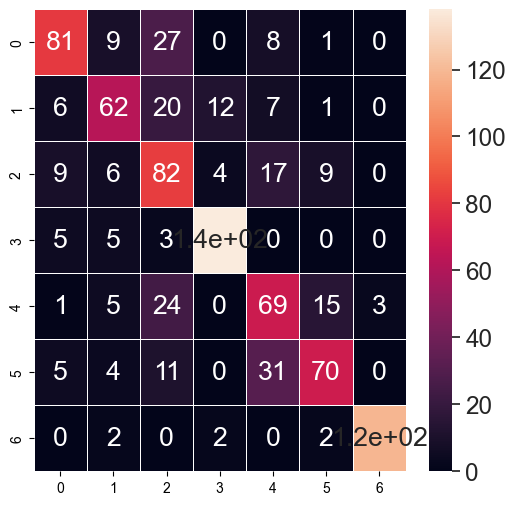

In [48]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


Text(0, 0.5, 'Fraction of incorrect predictions')

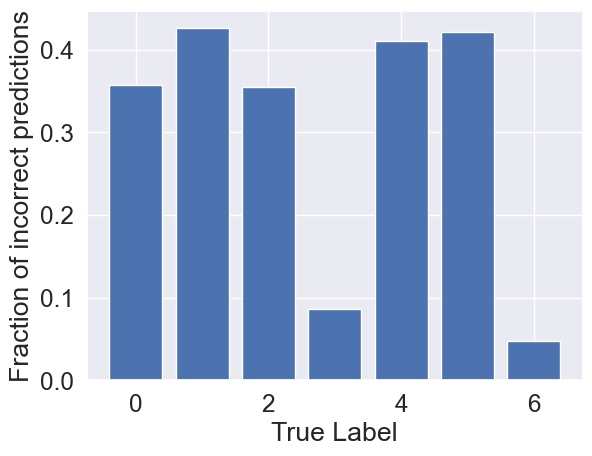

In [49]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
